In [1]:
#1. Importez les bibliothèques nécessaires et fixez la graine aléatoire à 42.

**ETAPE 1: Préparation des données**

Dans cette section, nous allons :
1.  Importer les bibliothèques Python nécessaires (PyTorch pour le Deep Learning, NumPy pour le calcul matriciel, Matplotlib/Seaborn pour la visualisation).
2.  Fixer la "graine aléatoire" (random seed) à 42. Cela garantit que les résultats sont reproductibles : chaque fois que vous lancez le code, les poids initiaux et la séparation des données seront identiques.
3.  Configurer le périphérique (Device) pour utiliser le GPU s'il est disponible, sinon le CPU.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns

# 1. Fixer la graine aléatoire pour la reproductibilité
torch.manual_seed(42)
np.random.seed(42)

# 2. La détection automatique du matériel configure l’exécution sur GPU si disponible, avec repli sur CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Un jeu de données non linéairement séparable est généré pour étudier la généralisation des modèles :

* Topologie lunaire : make_moons(n_samples=500, noise=0.2) produisant deux demi-cercles imbriqués.

* Topologie concentrique : make_circles(n_samples=500, noise=0.2, factor=0.5) produisant des classes radiales, ensuite translatées pour distinction spatiale.

Le jeu final contient N = 1000 échantillons répartis en deux classes équilibrées.

Unique classes in y: [0. 1.]
Number of classes: 2
Training set: torch.Size([700, 2]), torch.Size([700])
Test set: torch.Size([300, 2]), torch.Size([300])
Y train unique: tensor([0, 1])
Y test unique: tensor([0, 1])


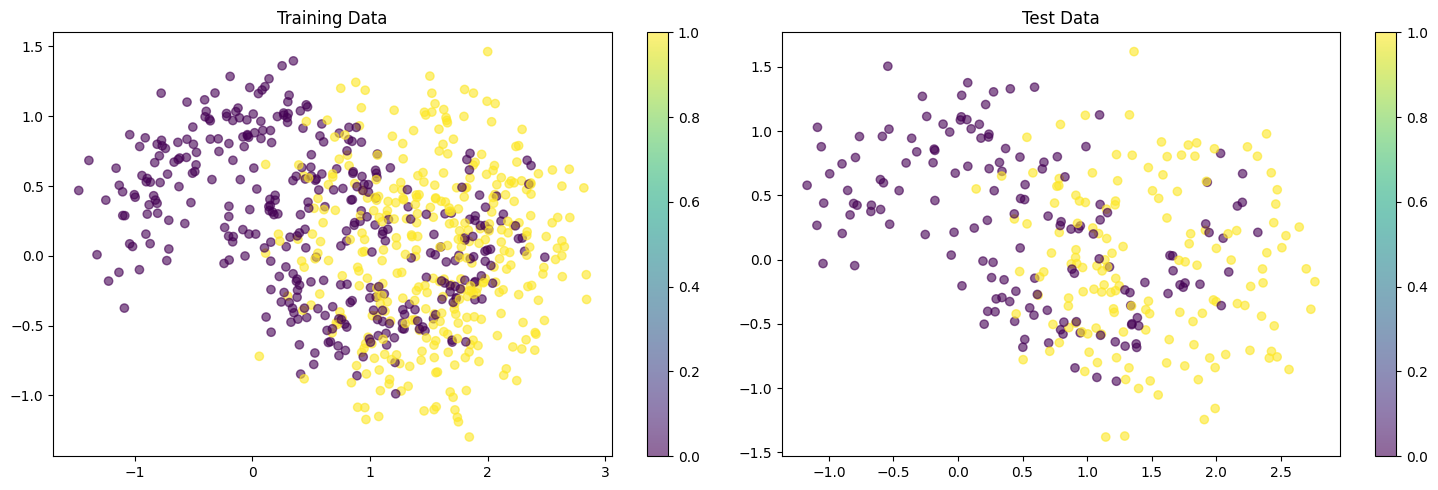

In [3]:
def create_complex_dataset(n_samples=1000, noise=0.3):
    # Générer la première moitié des données (Lunes)
    X1, y1 = make_moons(n_samples=n_samples//2, noise=noise, random_state=42)
    # Générer la seconde moitié (Cercles concentriques)
    X2, y2 = make_circles(n_samples=n_samples//2, noise=noise, random_state=42, factor=0.5)
    
    # Décaler les cercles pour qu'ils soient à côté des lunes
    X2 = X2 + np.array([1.5, 0])
    
    # Combiner les caractéristiques (features)
    X = np.vstack([X1, X2])
    # Combiner les étiquettes (labels). On garde 0 et 1 comme classes.
    y = np.hstack([y1, y2 + 2])  
    y = np.hstack([np.zeros(len(y1)), np.ones(len(y2))])
    return X, y

# Créer le dataset
X, y = create_complex_dataset(1000, noise=0.2)

print(f"Unique classes in y: {np.unique(y)}")
print(f"Number of classes: {len(np.unique(y))}")

# 3. Un échantillonnage stratifié sépare les données en 70 % entraînement et 30 % test
# stratify=y assure que la proportion de classes (0 et 1) est la même dans train et test.
X_train, X_test, y_train, y_test = train_test_split( X ,y, test_size=0.3, random_state=42, stratify=y)

# Convertir les tableaux Numpy en Tenseurs PyTorch et les envoyer sur le GPU/CPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)  
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)    

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"Y train unique: {torch.unique(y_train)}")
print(f"Y test unique: {torch.unique(y_test)}")

# Visualisation des données
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train.cpu()[:, 0], X_train.cpu()[:, 1], c=y_train.cpu(), cmap='viridis', alpha=0.6)
plt.title("Training Data")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_test.cpu()[:, 0], X_test.cpu()[:, 1], c=y_test.cpu(), cmap='viridis', alpha=0.6)
plt.title("Test Data")
plt.colorbar()

plt.tight_layout()
plt.show()

**Etape 2: entraînement avec batch gradient descent**

Ici, nous définissons l'architecture de notre réseau de neurones et la fonction d'entraînement.
* **Architecture** : 4 couches linéaires (`Linear`) connectées. La fonction d'activation `ReLU` est utilisée après chaque couche cachée pour introduire de la non-linéarité.
* **Batch Gradient Descent** : Le modèle verra tout le dataset d'un coup pour calculer le gradient.

**Baseline Model**
- Créer une classe SimpleNN héritant de nn.Module.
- Définir les couches linéaires (fc1, fc2, fc3, fc4) et une fonction d’activation finale ReLU.
- Implémenter la méthode forward(x) pour décrire le passage des données dans le réseau.

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, output_size=2):  
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Définition des couches cachées et de sortie
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        # Passage à travers les couches avec activation
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x) # Pas d'activation finale car CrossEntropyLoss l'inclut
        return x

def train_model(model, X_train, y_train, X_test, y_test, 
                epochs=1000, learning_rate=0.01, verbose=True):
    """Train model and return training history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)
        
        # Rétropropagation
        train_loss.backward()
        
        optimizer.step()
        
        _, train_pred = torch.max(outputs, 1)
        train_acc = (train_pred == y_train).float().mean()
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, test_pred = torch.max(test_outputs, 1)
            test_acc = (test_pred == y_test).float().mean()
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_acc.item())
        test_accuracies.append(test_acc.item())
        
        if verbose and (epoch % 100 == 0 or epoch == epochs-1):
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {train_loss.item():.4f}, '
                  f'Test Loss: {test_loss.item():.4f}, '
                  f'Train Acc: {train_acc.item():.4f}, '
                  f'Test Acc: {test_acc.item():.4f}')
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

In [5]:
print("\n" + "=" * 60)
print("Etape 2: BATCH GRADIENT DESCENT (FULL DATASET)")
print("=" * 60)


Etape 2: BATCH GRADIENT DESCENT (FULL DATASET)


Epoch [1/500], Train Loss: 0.6888, Test Loss: 0.6841, Train Acc: 0.7171, Test Acc: 0.7067
Epoch [101/500], Train Loss: 0.5039, Test Loss: 0.4981, Train Acc: 0.7514, Test Acc: 0.7433
Epoch [201/500], Train Loss: 0.4924, Test Loss: 0.4855, Train Acc: 0.7557, Test Acc: 0.7467
Epoch [301/500], Train Loss: 0.4834, Test Loss: 0.4780, Train Acc: 0.7543, Test Acc: 0.7500
Epoch [401/500], Train Loss: 0.4745, Test Loss: 0.4723, Train Acc: 0.7457, Test Acc: 0.7433
Epoch [500/500], Train Loss: 0.4722, Test Loss: 0.4744, Train Acc: 0.7471, Test Acc: 0.7100


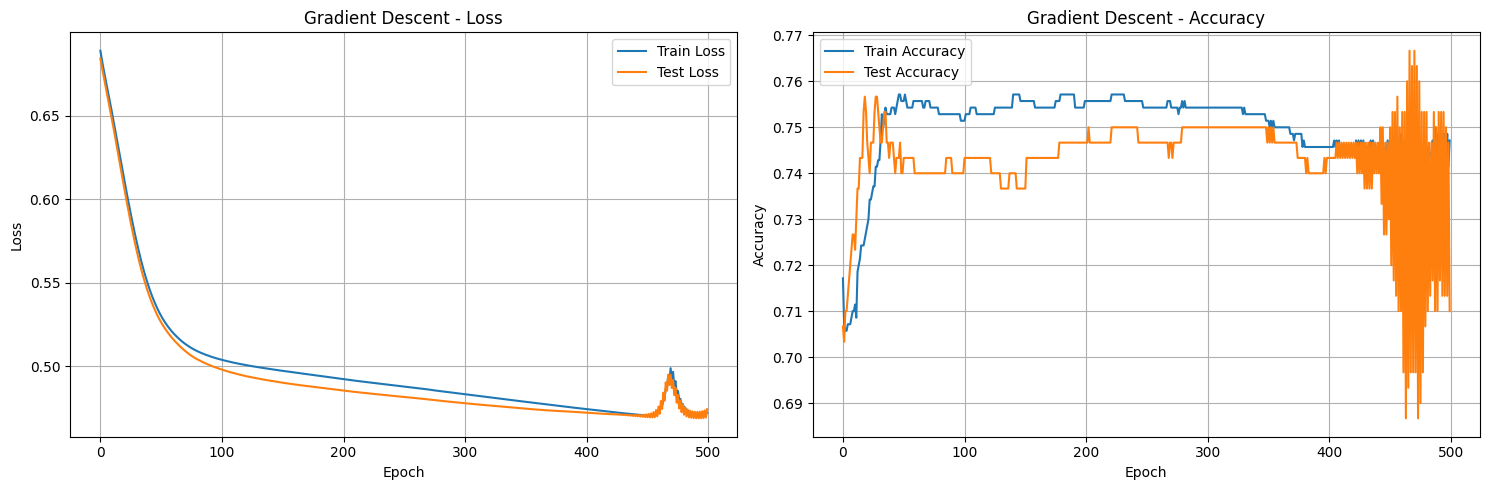

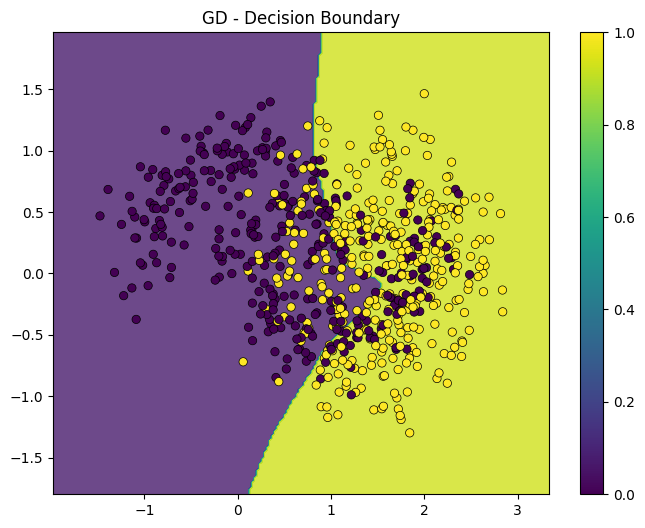

In [6]:
# Instancier le réseau SimpleNN avec une couche cachée de 100 neurones et une sortie de 2 classes :
batch_gd_model = SimpleNN(hidden_size=100, output_size=2).to(device)
# Utiliser SGD (Stochastic Gradient Descent) avec un taux d’apprentissage de 0.1 :
optimizer = optim.SGD(batch_gd_model.parameters(), lr=0.1)  
# Définir la fonction de perte CrossEntropyLoss adaptée à la classification 
# Criterion
criterion = nn.CrossEntropyLoss()

batch_gd_losses = []
batch_gd_accuracies = []
test_losses_batch = []
test_accuracies_batch = []

for epoch in range(500): 
    batch_gd_model.train()
    optimizer.zero_grad()
    # Batch GD: On passe tout X_train d'un coup
    outputs = batch_gd_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    _, pred = torch.max(outputs, 1)
    acc = (pred == y_train).float().mean()
    
    batch_gd_model.eval()
    with torch.no_grad():
        test_outputs = batch_gd_model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test).float().mean()
    
    batch_gd_losses.append(loss.item())
    batch_gd_accuracies.append(acc.item())
    test_losses_batch.append(test_loss.item())
    test_accuracies_batch.append(test_acc.item())   
    if epoch % 100 == 0 or epoch == 499:
        print(f'Epoch [{epoch+1}/500], '
              f'Train Loss: {loss.item():.4f}, '
              f'Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {acc.item():.4f}, '
              f'Test Acc: {test_acc.item():.4f}')

batch_gd_history = {
    'train_losses': batch_gd_losses,
    'test_losses': test_losses_batch,
    'train_accuracies': batch_gd_accuracies,
    'test_accuracies': test_accuracies_batch
}

# Fonction pour tracer les courbes de perte et précision
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['test_accuracies'], label='Test Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Fonction pour visualiser la frontière de décision
def plot_decision_boundary(model, X, y, title):
    """Plot decision boundary of the model"""
    model.eval()
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict on mesh grid
    with torch.no_grad():
        mesh_data = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
        Z = model(mesh_data)
        Z = torch.argmax(Z, dim=1).cpu().numpy()
    
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
    scatter = plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu(), 
                         cmap='viridis', edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()
    
plot_training_history(batch_gd_history, "Gradient Descent")
plot_decision_boundary(batch_gd_model, X_train, y_train, "GD - Decision Boundary")

**Quels signes observez-vous dans ce modèle?**

**Observation:**
La courbe de perte est très lisse (peu de bruit) car le gradient est calculé sur l'ensemble des données exactes à chaque étape. Cependant, le modèle commence à montrer des signes de **surapprentissage** (overfitting) : la perte d'entraînement continue de diminuer tandis que la perte de test stagne ou remonte légèrement, créant un écart (gap) entre les deux courbes.

In [7]:
print("\n" + "=" * 60)
print("Etape 3: MINI-BATCH GRADIENT DESCENT")
print("=" * 60)


Etape 3: MINI-BATCH GRADIENT DESCENT


Epoch [1/500], Train Loss: 0.6932, Test Loss: 0.6852, Train Acc: 0.5000, Test Acc: 0.5000
Epoch [101/500], Train Loss: 0.4894, Test Loss: 0.4822, Train Acc: 0.7543, Test Acc: 0.7467
Epoch [201/500], Train Loss: 0.4755, Test Loss: 0.4702, Train Acc: 0.7386, Test Acc: 0.7367
Epoch [301/500], Train Loss: 0.4680, Test Loss: 0.4643, Train Acc: 0.7429, Test Acc: 0.7333
Epoch [401/500], Train Loss: 0.4614, Test Loss: 0.4813, Train Acc: 0.7400, Test Acc: 0.7000
Epoch [500/500], Train Loss: 0.4547, Test Loss: 0.4548, Train Acc: 0.7457, Test Acc: 0.7267


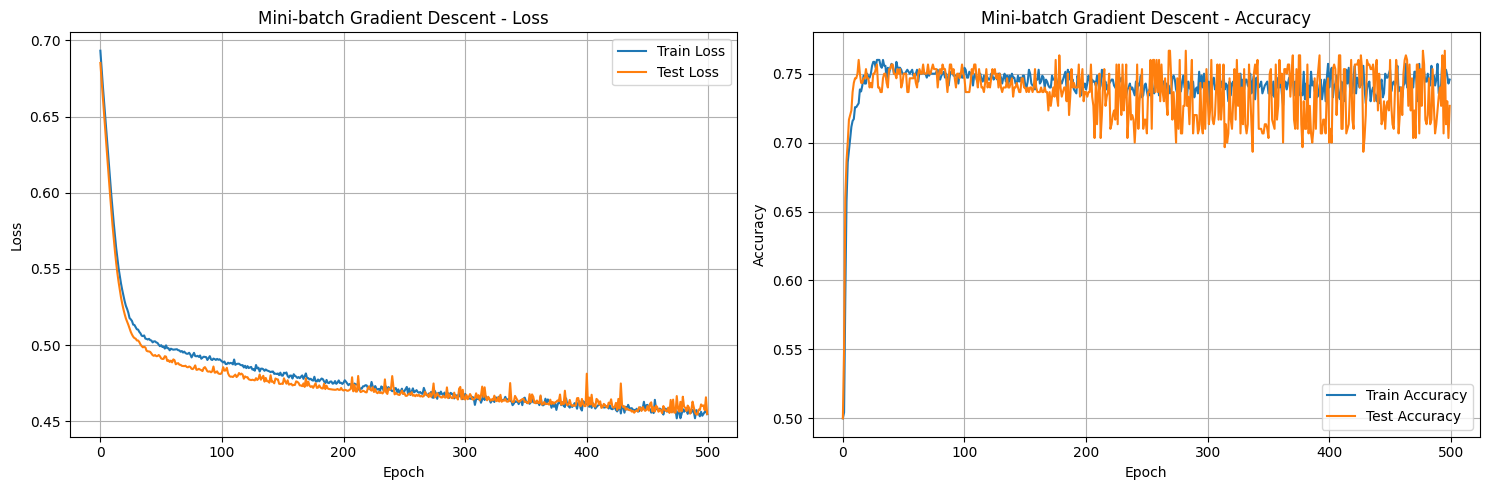

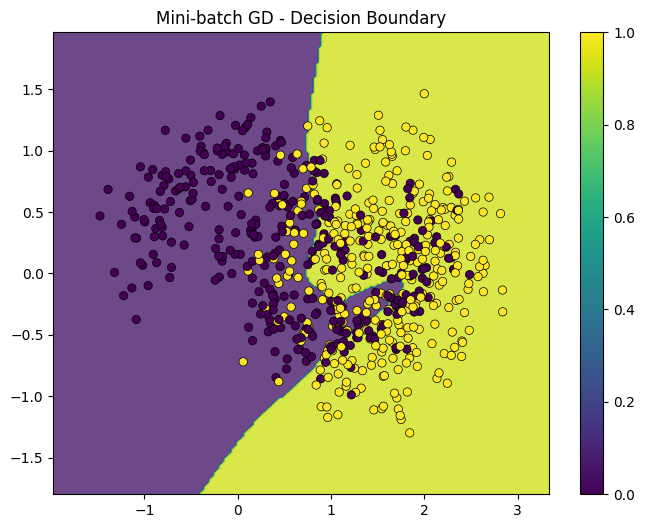


Mini-batch Details:
Batch size: 32
Number of batches per epoch: 22
Samples per batch: 31


In [8]:
# Instancier le réseau SimpleNN avec une couche cachée de 100 neurones et une sortie de 2 classes :
mini_batch_model = SimpleNN(hidden_size=100, output_size=2).to(device)
# Utiliser SGD (Stochastic Gradient Descent) avec un taux d’apprentissage de 0.01 
optimizer = optim.SGD(mini_batch_model.parameters(), lr=0.01)
# Définir la fonction de perte CrossEntropyLoss adaptée à la classification 
criterion = nn.CrossEntropyLoss()
# Utiliser DataLoader pour diviser les données en lots de taille 32
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
# Définition du DataLoader avec shuffle=True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

mini_batch_losses = []
mini_batch_accuracies = []
test_losses_mini = []
test_accuracies_mini = []

for epoch in range(500):
    # Training - Mini-batch loop
    mini_batch_model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    
    # Itération sur le loader
    for batch_X, batch_y in train_loader:  
        optimizer.zero_grad()
        outputs = mini_batch_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        epoch_correct += (pred == batch_y).sum().item()
        epoch_total += batch_y.size(0)
    
    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_correct / epoch_total
    
    mini_batch_model.eval()
    with torch.no_grad():
        test_outputs = mini_batch_model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test).float().mean()
    
    mini_batch_losses.append(avg_loss)
    mini_batch_accuracies.append(avg_acc)
    test_losses_mini.append(test_loss.item())
    test_accuracies_mini.append(test_acc.item())  
    if epoch % 100 == 0 or epoch == 499:
        print(f'Epoch [{epoch+1}/500], '
              f'Train Loss: {avg_loss:.4f}, '
              f'Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {avg_acc:.4f}, '
              f'Test Acc: {test_acc.item():.4f}')

mini_batch_history = {
    'train_losses': mini_batch_losses,
    'test_losses': test_losses_mini,
    'train_accuracies': mini_batch_accuracies,
    'test_accuracies': test_accuracies_mini
}

plot_training_history(mini_batch_history, "Mini-batch Gradient Descent")
plot_decision_boundary(mini_batch_model, X_train, y_train, "Mini-batch GD - Decision Boundary")

print(f"\nMini-batch Details:")
print(f"Batch size: {batch_size}")
print(f"Number of batches per epoch: {len(train_loader)}")
print(f"Samples per batch: {len(train_loader.dataset) // len(train_loader)}")

**Quels signes observez-vous dans ce modèle?**

**Observation:**
Les courbes sont légèrement plus bruitées (oscillantes) qu'en Batch GD pur. C'est normal car chaque mini-batch est une approximation du vrai dataset. Cependant, la convergence est souvent plus rapide en termes d'époques car les poids sont mis à jour plusieurs fois par époque (ici, environ 22 fois par époque).

In [9]:
print("\n" + "=" * 60)
print("Etape 4: STOCHASTIC GRADIENT DESCENT (SGD) - BATCH SIZE = 1")
print("=" * 60)


Etape 4: STOCHASTIC GRADIENT DESCENT (SGD) - BATCH SIZE = 1


Epoch [1/100], Train Loss: 0.6701, Test Loss: 0.6510, Train Acc: 0.6729, Test Acc: 0.7400
Epoch [21/100], Train Loss: 0.5027, Test Loss: 0.4916, Train Acc: 0.7429, Test Acc: 0.7500
Epoch [41/100], Train Loss: 0.4928, Test Loss: 0.4891, Train Acc: 0.7514, Test Acc: 0.7333
Epoch [61/100], Train Loss: 0.4863, Test Loss: 0.4758, Train Acc: 0.7443, Test Acc: 0.7533
Epoch [81/100], Train Loss: 0.4787, Test Loss: 0.4724, Train Acc: 0.7457, Test Acc: 0.7400
Epoch [100/100], Train Loss: 0.4700, Test Loss: 0.4691, Train Acc: 0.7471, Test Acc: 0.7200


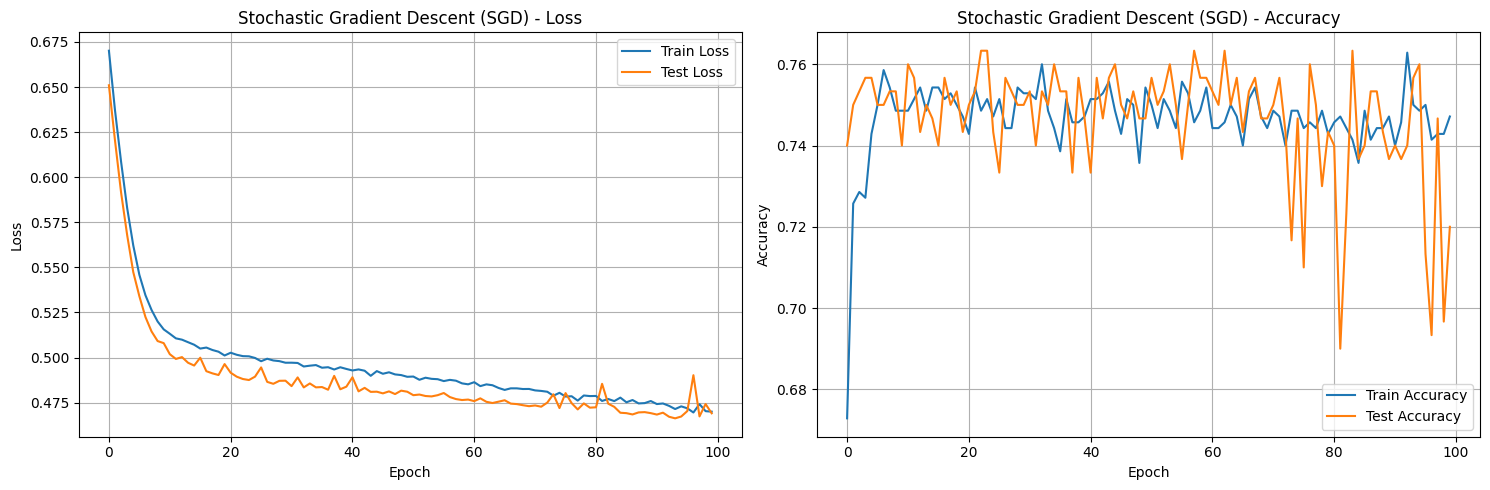

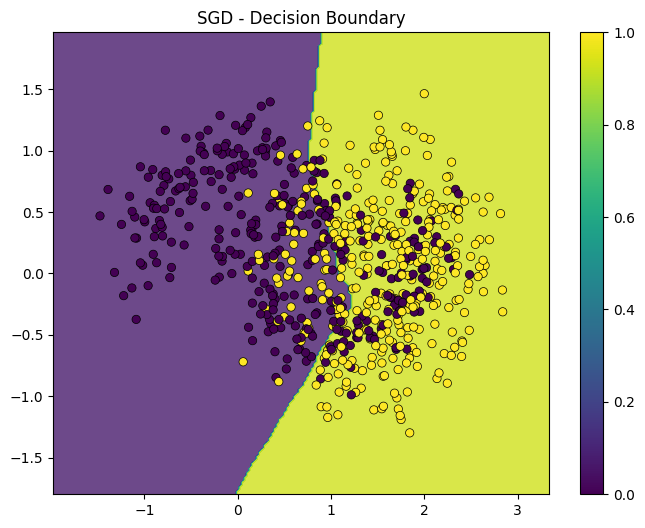


SGD Details:
Batch size: 1
Number of updates per epoch: 700
Total weight updates: 70,000


In [10]:
# Instancier le réseau SimpleNN avec une couche cachée de 100 neurones et une sortie de 2 classes 
sgd_model = SimpleNN(hidden_size=100, output_size=2).to(device)
# Utiliser SGD avec un taux d’apprentissage réduit (0.001)
# Taux d'apprentissage faible pour compenser le bruit extrême
optimizer = optim.SGD(sgd_model.parameters(), lr=0.001) 
# Définir la fonction de perte 
criterion = nn.CrossEntropyLoss()

sgd_batch_size = 1
# Loader avec batch_size = 1
sgd_train_loader = DataLoader(train_dataset, batch_size=sgd_batch_size, shuffle=True)

sgd_losses = []
sgd_accuracies = []
test_losses_sgd = []
test_accuracies_sgd = []

for epoch in range(100):  
    sgd_model.train()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    
    for batch_idx, (batch_X, batch_y) in enumerate(sgd_train_loader):
        optimizer.zero_grad()
        outputs = sgd_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        epoch_correct += (pred == batch_y).sum().item()
        epoch_total += batch_y.size(0)
    
    avg_loss = epoch_loss / len(sgd_train_loader)
    avg_acc = epoch_correct / epoch_total
    
    sgd_model.eval()
    with torch.no_grad():
        test_outputs = sgd_model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test).float().mean()
    
    sgd_losses.append(avg_loss)
    sgd_accuracies.append(avg_acc)
    test_losses_sgd.append(test_loss.item())
    test_accuracies_sgd.append(test_acc.item())
    
    if epoch % 20 == 0 or epoch == 99:
        print(f'Epoch [{epoch+1}/100], '
              f'Train Loss: {avg_loss:.4f}, '
              f'Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {avg_acc:.4f}, '
              f'Test Acc: {test_acc.item():.4f}')

sgd_history = {
    'train_losses': sgd_losses,
    'test_losses': test_losses_sgd,
    'train_accuracies': sgd_accuracies,
    'test_accuracies': test_accuracies_sgd
}

plot_training_history(sgd_history, "Stochastic Gradient Descent (SGD)")
plot_decision_boundary(sgd_model, X_train, y_train, "SGD - Decision Boundary")

print(f"\nSGD Details:")
print(f"Batch size: {sgd_batch_size}")
print(f"Number of updates per epoch: {len(sgd_train_loader)}")
print(f"Total weight updates: {100 * len(sgd_train_loader):,}")  # epochs * batches

**Quels signes observez-vous dans ce modèle?**

**Observation:**
La courbe de perte est extrêmement bruitée et instable. Le modèle met à jour ses poids après chaque exemple unique, ce qui le fait "zigzaguer" vers la solution. Le temps d'entraînement par époque est beaucoup plus long car nous perdons l'avantage de la vectorisation (calcul parallèle sur GPU).

**Etape 5: Re-entraîner le modèle en Mini-batch avec Adam**

Adam est un optimiseur adaptatif qui combine les avantages de Momentum et RMSProp. Il converge généralement beaucoup plus vite que SGD standard.


Etape 5: ADAM OPTIMIZER
Epoch [1/200], Train Loss: 0.7007, Test Loss: 0.6520, Train Acc: 0.5000, Test Acc: 0.6267
Epoch [101/200], Train Loss: 0.4105, Test Loss: 0.4600, Train Acc: 0.7829, Test Acc: 0.7533
Epoch [200/200], Train Loss: 0.3578, Test Loss: 0.5451, Train Acc: 0.8229, Test Acc: 0.7367


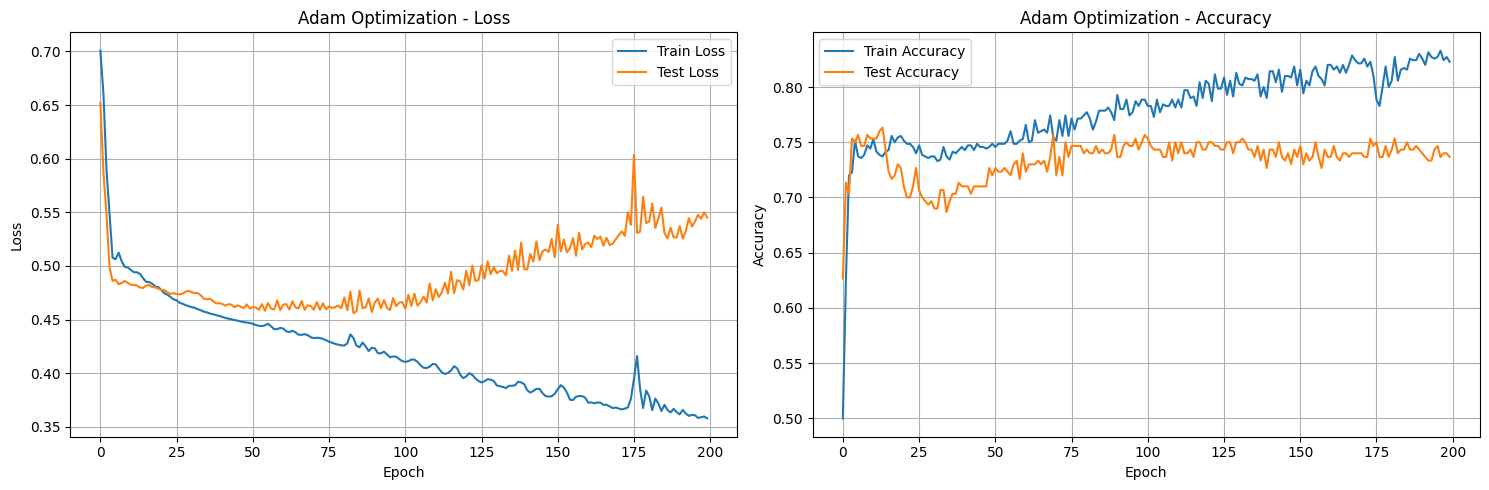

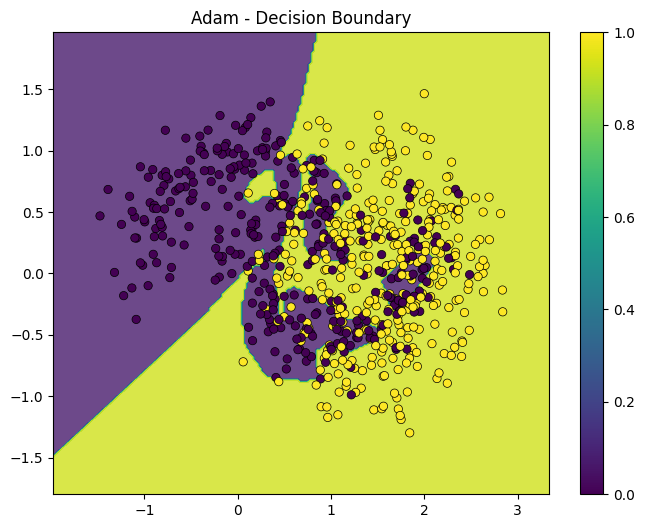

In [11]:
# Utilisation de l'optimiseur Adam
print("\n" + "=" * 60)
print("Etape 5: ADAM OPTIMIZER")
print("=" * 60)

adam_model = SimpleNN(hidden_size=100, output_size=2).to(device)
optimizer = optim.Adam(adam_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Réutiliser le loader mini-batch (taille 32)
adam_history = train_model(adam_model, X_train, y_train, X_test, y_test, 
                           epochs=200, learning_rate=0.01) # Moins d'époques nécessaires

plot_training_history(adam_history, "Adam Optimization")
plot_decision_boundary(adam_model, X_train, y_train, "Adam - Decision Boundary")

**Quels signes observez-vous dans en utilisant Adam avec mini-batch?**

**Observation:**
Adam converge beaucoup plus rapidement que SGD. La perte chute drastiquement dès les premières époques. Il est capable de gérer des taux d'apprentissage plus élevés sans diverger aussi facilement que SGD.

**Simulation 1**
* **But:** Observer le comportement d'un modèle profond entraîné longtemps.
* **Attente:** Risque de surapprentissage (Overfitting).

Epoch [1/1000], Train Loss: 0.7054, Test Loss: 0.6695, Train Acc: 0.5000, Test Acc: 0.6433
Epoch [101/1000], Train Loss: 0.4172, Test Loss: 0.4610, Train Acc: 0.7900, Test Acc: 0.7467
Epoch [201/1000], Train Loss: 0.3701, Test Loss: 0.5647, Train Acc: 0.8214, Test Acc: 0.7400
Epoch [301/1000], Train Loss: 0.3327, Test Loss: 0.6847, Train Acc: 0.8457, Test Acc: 0.7367
Epoch [401/1000], Train Loss: 0.3024, Test Loss: 0.7698, Train Acc: 0.8657, Test Acc: 0.7433
Epoch [501/1000], Train Loss: 0.2918, Test Loss: 0.9992, Train Acc: 0.8671, Test Acc: 0.7500
Epoch [601/1000], Train Loss: 0.2588, Test Loss: 0.9505, Train Acc: 0.8729, Test Acc: 0.7400
Epoch [701/1000], Train Loss: 0.2533, Test Loss: 1.0058, Train Acc: 0.8829, Test Acc: 0.7367
Epoch [801/1000], Train Loss: 0.2440, Test Loss: 1.0736, Train Acc: 0.8814, Test Acc: 0.7400
Epoch [901/1000], Train Loss: 0.2156, Test Loss: 1.2255, Train Acc: 0.8971, Test Acc: 0.7300
Epoch [1000/1000], Train Loss: 0.2705, Test Loss: 1.3972, Train Acc: 0.8

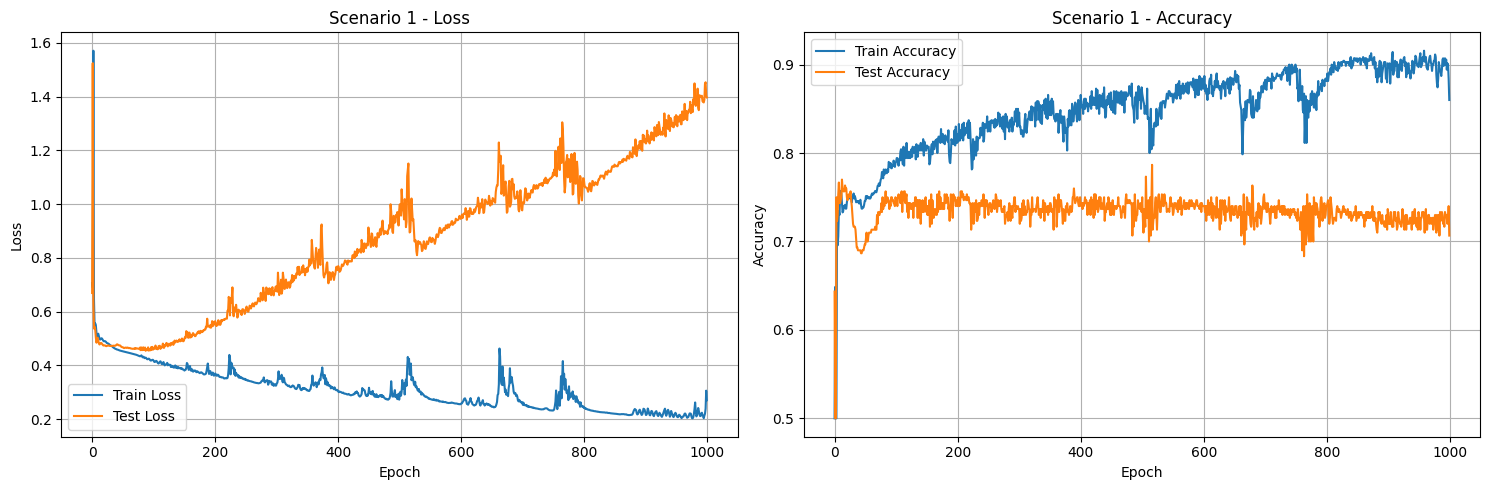

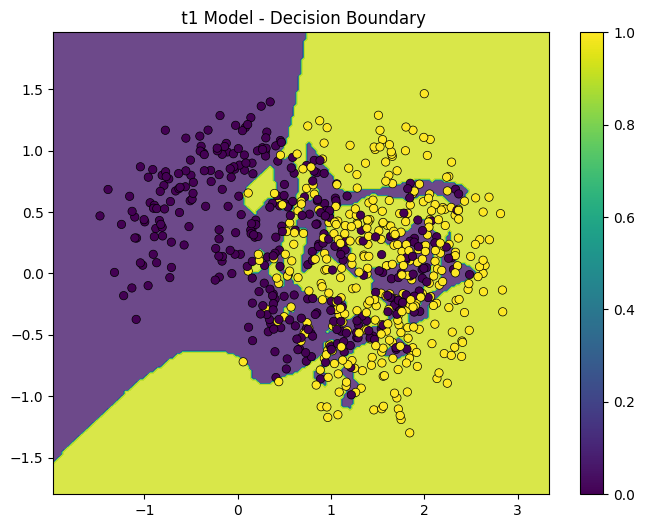

In [12]:
t1_model = SimpleNN(hidden_size=200, output_size=2).to(device)  
t1_history = train_model(t1_model, X_train, y_train, X_test, y_test, 
                             epochs=1000, learning_rate=0.01)

def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['test_accuracies'], label='Test Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(t1_history, "Scenario 1")

# Visualize decision boundaries
def plot_decision_boundary(model, X, y, title):
    """Plot decision boundary of the model"""
    model.eval()
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    with torch.no_grad():
        mesh_data = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
        Z = model(mesh_data)
        Z = torch.argmax(Z, dim=1).cpu().numpy()
    
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
    scatter = plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu(), 
                         cmap='viridis', edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

plot_decision_boundary(t1_model, X_train, y_train, " t1 Model - Decision Boundary")

**Quels signes observez-vous dans ce modèle?**

**Observation:**
Le modèle atteint une précision d'entraînement presque parfaite (100%), mais la précision de test stagne. L'écart entre Loss Train et Loss Test grandit : c'est la signature classique du surapprentissage. Le modèle "apprend par cœur" les données d'entraînement au lieu de généraliser.

**Simulation 2**
* **But:** Créer un modèle très petit (Underfitting).
* **Modèle:** Seulement 5 neurones dans la couche cachée.

Training model 2...
Epoch [1/1000], Train Loss: 0.8043, Test Loss: 0.7941, Train Acc: 0.5000, Test Acc: 0.5000
Epoch [101/1000], Train Loss: 0.5010, Test Loss: 0.4887, Train Acc: 0.7500, Test Acc: 0.7567
Epoch [201/1000], Train Loss: 0.5007, Test Loss: 0.4878, Train Acc: 0.7500, Test Acc: 0.7533
Epoch [301/1000], Train Loss: 0.5005, Test Loss: 0.4883, Train Acc: 0.7543, Test Acc: 0.7633
Epoch [401/1000], Train Loss: 0.5004, Test Loss: 0.4882, Train Acc: 0.7543, Test Acc: 0.7633
Epoch [501/1000], Train Loss: 0.5004, Test Loss: 0.4882, Train Acc: 0.7543, Test Acc: 0.7633
Epoch [601/1000], Train Loss: 0.5004, Test Loss: 0.4882, Train Acc: 0.7543, Test Acc: 0.7600
Epoch [701/1000], Train Loss: 0.5004, Test Loss: 0.4882, Train Acc: 0.7543, Test Acc: 0.7600
Epoch [801/1000], Train Loss: 0.5003, Test Loss: 0.4883, Train Acc: 0.7543, Test Acc: 0.7633
Epoch [901/1000], Train Loss: 0.5003, Test Loss: 0.4882, Train Acc: 0.7543, Test Acc: 0.7600
Epoch [1000/1000], Train Loss: 0.5003, Test Loss: 0.

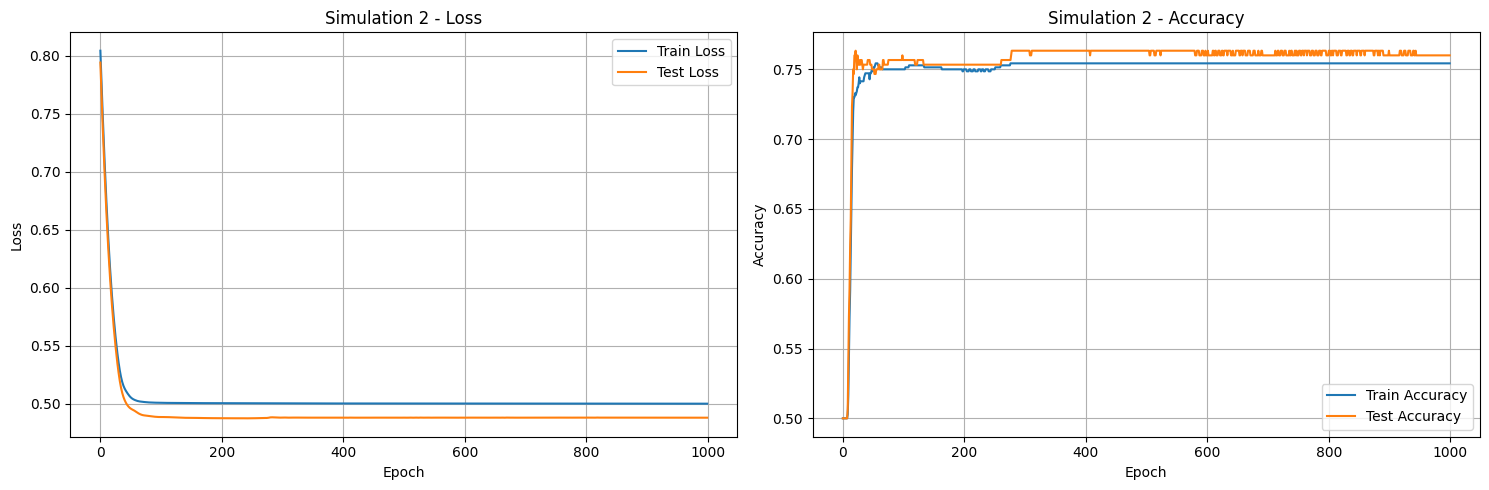

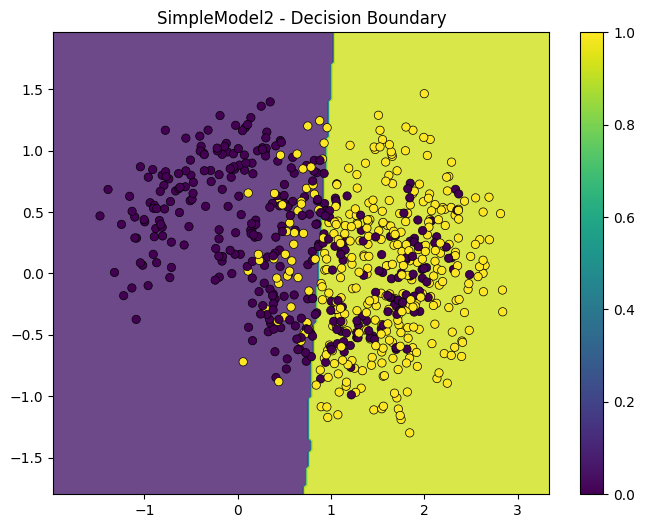

In [13]:
class SimpleModel2(nn.Module):
    def __init__(self, input_size=2, output_size=2):  
        super(SimpleModel2, self).__init__()
        self.fc1 = nn.Linear(input_size, 5)  # Seulement 5 neurones !
        self.fc2 = nn.Linear(5, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

t2_model = SimpleModel2(output_size=2).to(device)  
print("Training model 2...")
t2_history = train_model(t2_model, X_train, y_train, X_test, y_test, 
                              epochs=1000, learning_rate=0.01)

plot_training_history(t2_history, "Simulation 2")
plot_decision_boundary(t2_model, X_train, y_train, "SimpleModel2 - Decision Boundary")

**Quels signes observez-vous dans ce modèle?**

**Observation:**
Permet d’identifier le **sous-apprentissage (underfitting)** (pertes **élevées**, précision **faible**). Le modèle est trop simple pour capturer la forme complexe (Lunes + Cercles) des données. La frontière de décision ressemble à des lignes simples.

**Simulation 3**
* **But:** Utiliser un taux d'apprentissage trop élevé (0.5).
* **Attente:** Divergence ou instabilité.

Training model t3...


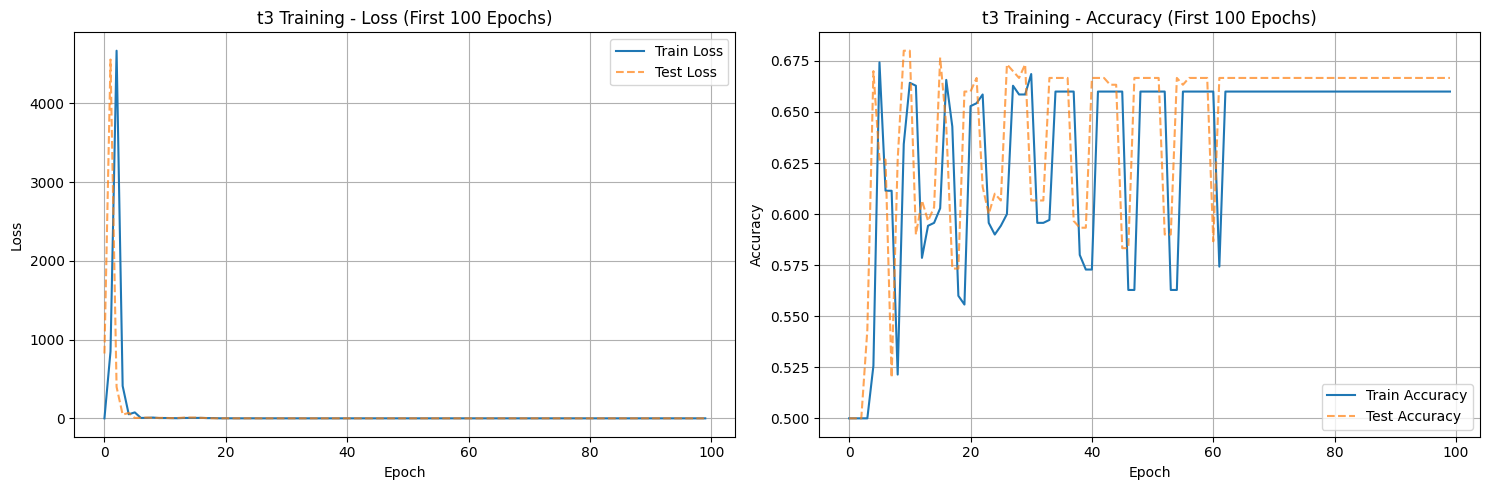

In [15]:
t3_model = SimpleNN(hidden_size=100, output_size=2).to(device)  
print("Training model t3...")

# Train for 500 epochs (instability usually shows up early)
t3_history = train_model(t3_model, X_train, y_train, X_test, y_test, 
                         epochs=500, learning_rate=0.5, verbose=False)  

plt.figure(figsize=(15, 5))

# --- PLOT 1: LOSS (Train vs Test) ---
plt.subplot(1, 2, 1)
# Plot first 100 epochs
plt.plot(t3_history['train_losses'][:100], label='Train Loss')
plt.plot(t3_history['test_losses'][:100], label='Test Loss', linestyle='--', alpha=0.7)
plt.title("t3 Training - Loss (First 100 Epochs)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- PLOT 2: ACCURACY (Train vs Test) ---
plt.subplot(1, 2, 2)
# Plot first 100 epochs
plt.plot(t3_history['train_accuracies'][:100], label='Train Accuracy')
plt.plot(t3_history['test_accuracies'][:100], label='Test Accuracy', linestyle='--', alpha=0.7)
plt.title("t3 Training - Accuracy (First 100 Epochs)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Régularisation**

Nous allons maintenant appliquer des techniques pour corriger le surapprentissage (Simulation 1).

**Simulation 5** : **L2 Regularization (Weight Decay)**
* Ajoute une pénalité proportionnelle au carré des poids à la fonction de perte.
* Force les poids à rester petits.

TESTER L2 REGULARIZATION
Epoch [1/1000], Train Loss: 0.6856, Test Loss: 0.6135, Train Acc: 0.6629, Test Acc: 0.7067
Epoch [201/1000], Train Loss: 0.4200, Test Loss: 0.4616, Train Acc: 0.7900, Test Acc: 0.7467
Epoch [401/1000], Train Loss: 0.4003, Test Loss: 0.4588, Train Acc: 0.8014, Test Acc: 0.7400
Epoch [601/1000], Train Loss: 0.3911, Test Loss: 0.4577, Train Acc: 0.8071, Test Acc: 0.7500
Epoch [801/1000], Train Loss: 0.3839, Test Loss: 0.4634, Train Acc: 0.8186, Test Acc: 0.7533
Epoch [1000/1000], Train Loss: 0.3765, Test Loss: 0.4680, Train Acc: 0.8171, Test Acc: 0.7567


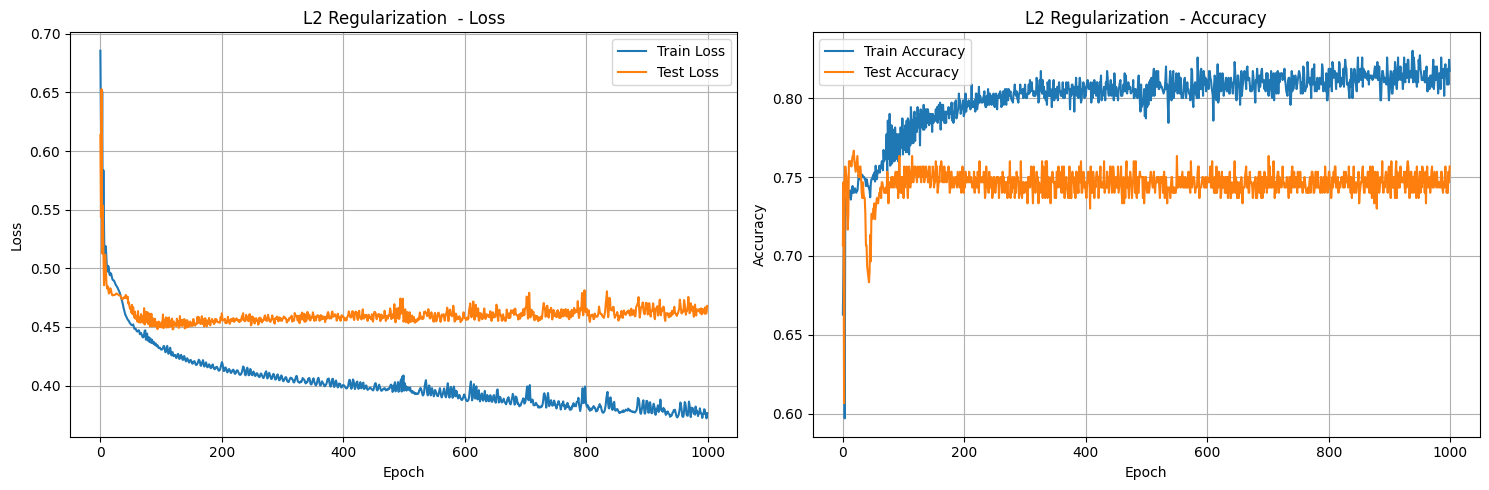

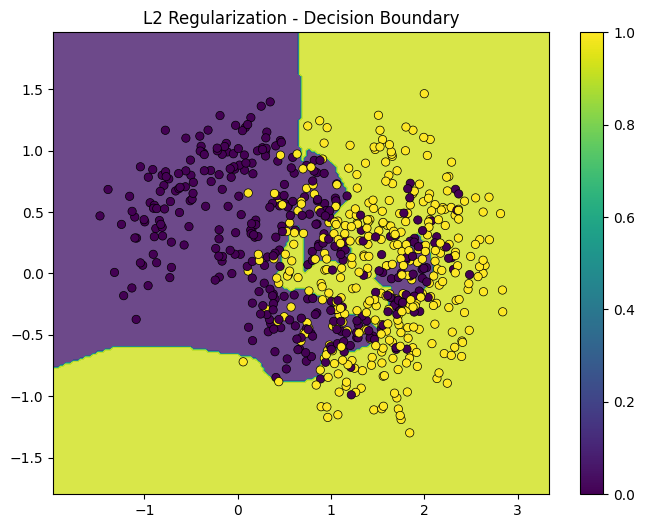


L2 Regularization Effect on Weights:
  fc1.weight: average |weight| = 0.209535
  fc2.weight: average |weight| = 0.019668
  fc3.weight: average |weight| = 0.012674
  fc4.weight: average |weight| = 0.180000
Overall average |weight|: 0.019673


In [16]:
print("=" * 60)
print("TESTER L2 REGULARIZATION")
print("=" * 60)
l2_only_model = SimpleNN(hidden_size=100, output_size=2).to(device)

# weight_decay=1e-3 active la régularisation L2 dans l'optimiseur Adam
optimizer = optim.Adam(l2_only_model.parameters(), lr=0.01, weight_decay=1e-3)  
criterion = nn.CrossEntropyLoss()

l2_only_losses = []
l2_only_accuracies = []
test_losses_l2 = []
test_accuracies_l2 = []

for epoch in range(1000):
    l2_only_model.train()
    optimizer.zero_grad()
    outputs = l2_only_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    _, pred = torch.max(outputs, 1)
    acc = (pred == y_train).float().mean()
    
    l2_only_model.eval()
    with torch.no_grad():
        test_outputs = l2_only_model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test).float().mean()
    
    l2_only_losses.append(loss.item())
    l2_only_accuracies.append(acc.item())
    test_losses_l2.append(test_loss.item())
    test_accuracies_l2.append(test_acc.item())
    
    if epoch % 200 == 0 or epoch == 999:
        print(f'Epoch [{epoch+1}/1000], '
              f'Train Loss: {loss.item():.4f}, '
              f'Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {acc.item():.4f}, '
              f'Test Acc: {test_acc.item():.4f}')

l2_only_history = {
    'train_losses': l2_only_losses,
    'test_losses': test_losses_l2,
    'train_accuracies': l2_only_accuracies,
    'test_accuracies': test_accuracies_l2
}

plot_training_history(l2_only_history, "L2 Regularization ")
plot_decision_boundary(l2_only_model, X_train, y_train, "L2 Regularization - Decision Boundary")

print("\nL2 Regularization Effect on Weights:")
total_weight_magnitude = 0
total_params = 0
for name, param in l2_only_model.named_parameters():
    if 'weight' in name:
        weight_mag = torch.mean(torch.abs(param)).item()
        print(f"  {name}: average |weight| = {weight_mag:.6f}")
        total_weight_magnitude += torch.sum(torch.abs(param)).item()
        total_params += param.numel()

print(f"Overall average |weight|: {total_weight_magnitude/total_params:.6f}")

**L’impact de L2 est: la **réduction** de la magnitude des poids et la **stabilisation** de l’entraînement.**

**Simulation 6** : **L1 Regularization**
* Ajoute une pénalité proportionnelle à la valeur absolue des poids.
* Encourage la "sparsité" (rend certains poids exactement égaux à zéro).

TESTER L1 REGULARIZATION
Epoch [1/1000], Train Loss: 1.8349, Test Loss: 0.6582, Train Acc: 0.5000, Test Acc: 0.5567
Epoch [201/1000], Train Loss: 0.5183, Test Loss: 0.4587, Train Acc: 0.7414, Test Acc: 0.7333
Epoch [401/1000], Train Loss: 0.5035, Test Loss: 0.4506, Train Acc: 0.7614, Test Acc: 0.7600
Epoch [601/1000], Train Loss: 0.5008, Test Loss: 0.4504, Train Acc: 0.7643, Test Acc: 0.7700
Epoch [801/1000], Train Loss: 0.4994, Test Loss: 0.4514, Train Acc: 0.7614, Test Acc: 0.7567
Epoch [1000/1000], Train Loss: 0.4969, Test Loss: 0.4511, Train Acc: 0.7657, Test Acc: 0.7667


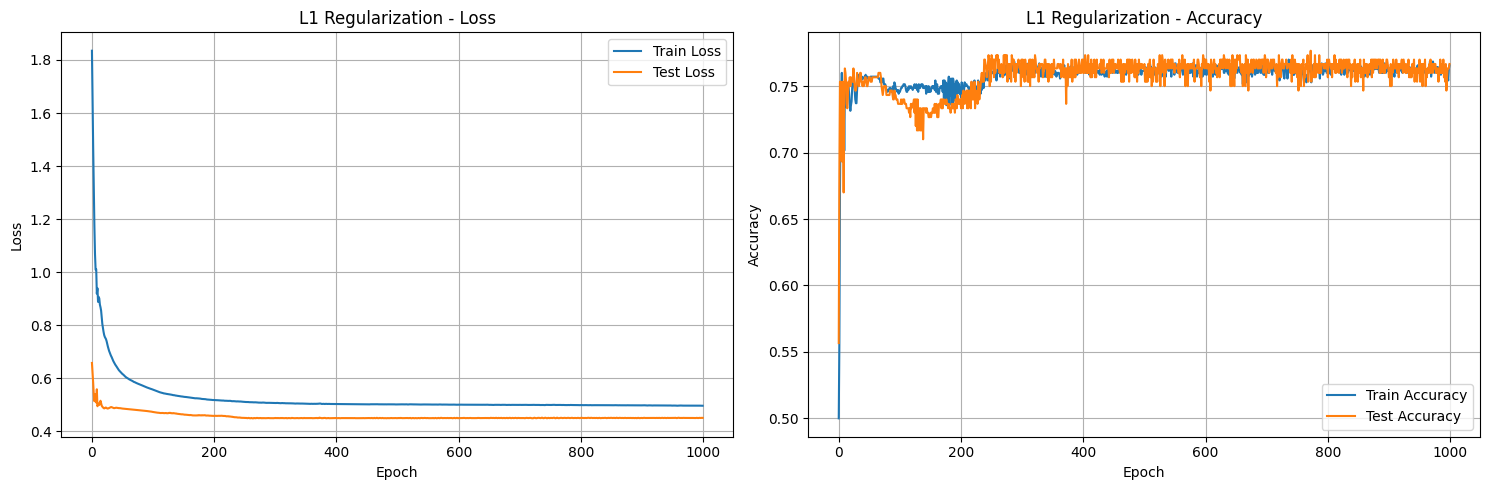

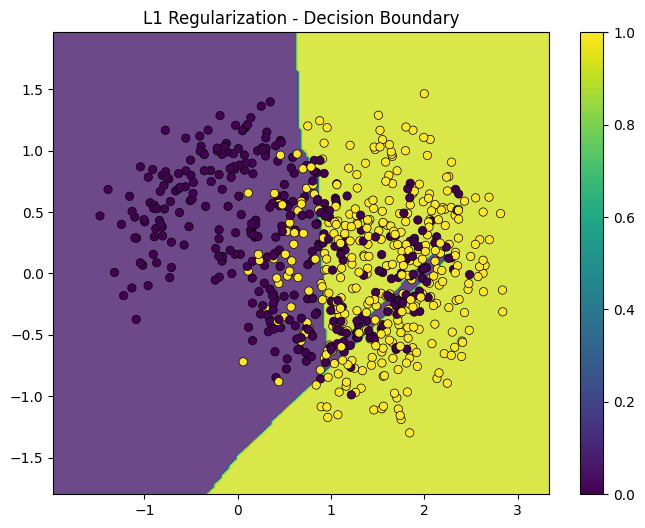


L1 Regularization Effect on Weights:
  fc1.weight: average |weight| = 0.025900
  fc2.weight: average |weight| = 0.001787
  fc3.weight: average |weight| = 0.001723
  fc4.weight: average |weight| = 0.028610
Overall average |weight|: 0.002255


In [17]:
print("=" * 60)
print("TESTER L1 REGULARIZATION")
print("=" * 60)

l1_only_model = SimpleNN(hidden_size=100, output_size=2).to(device)

# Use Adam without weight decay (L2)
optimizer = optim.Adam(l1_only_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

l1_lambda = 1e-3  # L1 regularization strength

l1_only_losses = []
l1_only_accuracies = []
test_losses_l1 = []
test_accuracies_l1 = []

for epoch in range(1000):
    l1_only_model.train()
    optimizer.zero_grad()
    outputs = l1_only_model(X_train)
    base_loss = criterion(outputs, y_train)

    # Calcul manuel de la pénalité L1
    l1_penalty = sum(torch.sum(torch.abs(param)) for param in l1_only_model.parameters()) 
    loss = base_loss + l1_lambda * l1_penalty

    loss.backward()
    optimizer.step()
    
    _, pred = torch.max(outputs, 1)
    acc = (pred == y_train).float().mean()
    
    l1_only_model.eval()
    with torch.no_grad():
        test_outputs = l1_only_model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test).float().mean()
    
    l1_only_losses.append(loss.item())
    l1_only_accuracies.append(acc.item())
    test_losses_l1.append(test_loss.item())
    test_accuracies_l1.append(test_acc.item())
    
    if epoch % 200 == 0 or epoch == 999:
        print(f'Epoch [{epoch+1}/1000], '
              f'Train Loss: {loss.item():.4f}, '
              f'Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {acc.item():.4f}, '
              f'Test Acc: {test_acc.item():.4f}')

l1_only_history = {
    'train_losses': l1_only_losses,
    'test_losses': test_losses_l1,
    'train_accuracies': l1_only_accuracies,
    'test_accuracies': test_accuracies_l1
}

plot_training_history(l1_only_history, "L1 Regularization")
plot_decision_boundary(l1_only_model, X_train, y_train, "L1 Regularization - Decision Boundary")

print("\nL1 Regularization Effect on Weights:")
total_weight_magnitude = 0
total_params = 0
for name, param in l1_only_model.named_parameters():
    if 'weight' in name:
        weight_mag = torch.mean(torch.abs(param)).item()
        print(f"  {name}: average |weight| = {weight_mag:.6f}")
        total_weight_magnitude += torch.sum(torch.abs(param)).item()
        total_params += param.numel()

print(f"Overall average |weight|: {total_weight_magnitude/total_params:.6f}")

**Simulation 7** : **Dropout**
* Désactive aléatoirement des neurones durant l'entraînement.
* Force le réseau à être robuste et redondant.


TESTER DROPOUT 
Epoch [1/1000], Train Loss: 0.6922, Test Loss: 0.6354, Train Acc: 0.4829, Test Acc: 0.6600
Epoch [201/1000], Train Loss: 0.4562, Test Loss: 0.4542, Train Acc: 0.7600, Test Acc: 0.7400
Epoch [401/1000], Train Loss: 0.4534, Test Loss: 0.4577, Train Acc: 0.7771, Test Acc: 0.7433
Epoch [601/1000], Train Loss: 0.4361, Test Loss: 0.4517, Train Acc: 0.7643, Test Acc: 0.7533
Epoch [801/1000], Train Loss: 0.4425, Test Loss: 0.4791, Train Acc: 0.7671, Test Acc: 0.7400
Epoch [1000/1000], Train Loss: 0.4424, Test Loss: 0.4863, Train Acc: 0.7657, Test Acc: 0.7433


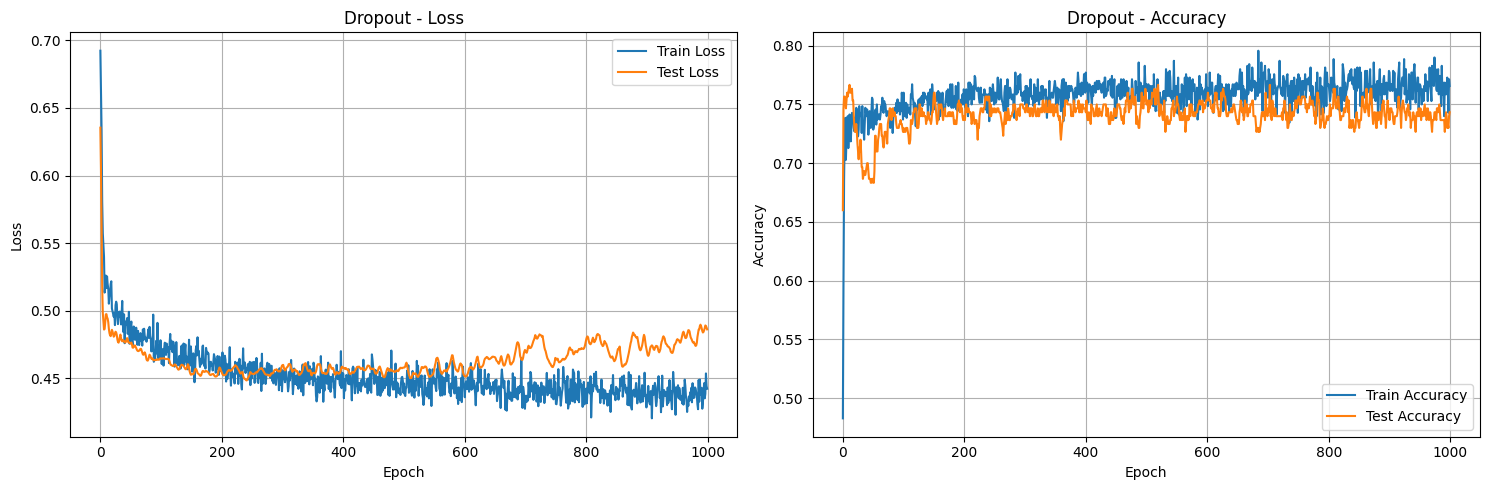

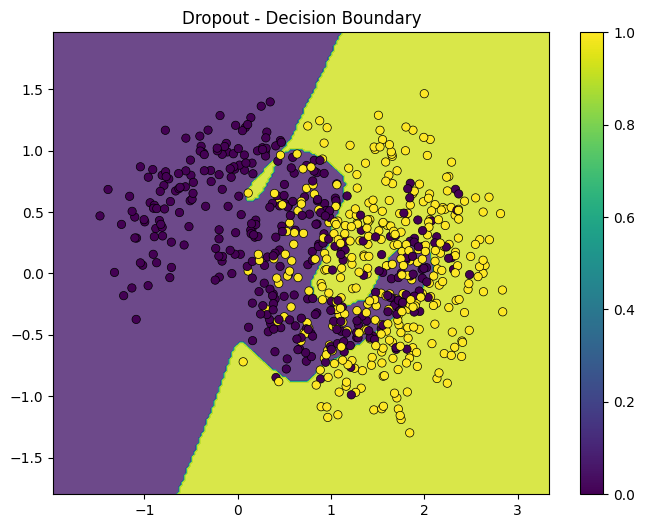


Dropout Effect Demonstration:
With dropout ON (training): output variations exist
With dropout OFF (evaluation): consistent outputs


In [18]:
class DropoutOnlyNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, output_size=2, dropout_rate=0.5):
        super(DropoutOnlyNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        # Couche Dropout
        self.dropout = nn.Dropout(dropout_rate)  
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)    # Appliquer Dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)    # Appliquer Dropout
        x = self.relu(self.fc3(x))
        x = self.dropout(x)    # Appliquer Dropout
        x = self.fc4(x)
        return x

print("\n" + "=" * 60)
print("TESTER DROPOUT ")
print("=" * 60)

dropout_only_model = DropoutOnlyNN(hidden_size=100, output_size=2, dropout_rate=0.5).to(device)

optimizer = optim.Adam(dropout_only_model.parameters(), lr=0.01, weight_decay=0)  
criterion = nn.CrossEntropyLoss()

dropout_only_losses = []
dropout_only_accuracies = []
test_losses_dropout = []
test_accuracies_dropout = []

for epoch in range(1000):
    dropout_only_model.train()
    optimizer.zero_grad()
    outputs = dropout_only_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    _, pred = torch.max(outputs, 1)
    acc = (pred == y_train).float().mean()
    
    dropout_only_model.eval()  
    with torch.no_grad():
        test_outputs = dropout_only_model(X_test)
        test_loss = criterion(test_outputs, y_test)
        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test).float().mean()
    
    dropout_only_losses.append(loss.item())
    dropout_only_accuracies.append(acc.item())
    test_losses_dropout.append(test_loss.item())
    test_accuracies_dropout.append(test_acc.item())
    
    if epoch % 200 == 0 or epoch == 999:
        print(f'Epoch [{epoch+1}/1000], '
              f'Train Loss: {loss.item():.4f}, '
              f'Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {acc.item():.4f}, '
              f'Test Acc: {test_acc.item():.4f}')

dropout_only_history = {
    'train_losses': dropout_only_losses,
    'test_losses': test_losses_dropout,
    'train_accuracies': dropout_only_accuracies,
    'test_accuracies': test_accuracies_dropout
}

plot_training_history(dropout_only_history, "Dropout")
plot_decision_boundary(dropout_only_model, X_train, y_train, "Dropout - Decision Boundary")

print("\nDropout Effect Demonstration:")
dropout_only_model.train()  
train_output = dropout_only_model(X_train[:5])  
print(f"With dropout ON (training): output variations exist")

dropout_only_model.eval()     
eval_output = dropout_only_model(X_train[:5])  
print(f"With dropout OFF (evaluation): consistent outputs")

**Conclusion du TP**
Nous avons vu comment différentes techniques d'optimisation (Batch vs SGD) affectent la vitesse et la stabilité de l'entraînement. Nous avons également démontré comment la régularisation (L2, L1, Dropout) est essentielle pour empêcher les modèles profonds de mémoriser le bruit des données, leur permettant ainsi de généraliser sur de nouvelles données.